In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import csv
from statsmodels.tsa.stattools import pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
month = '201707'

towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1003 and 1008 J/kg.K, thus we can assume it constant at 1005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

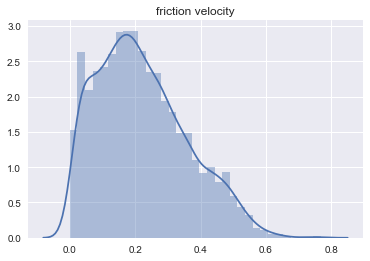

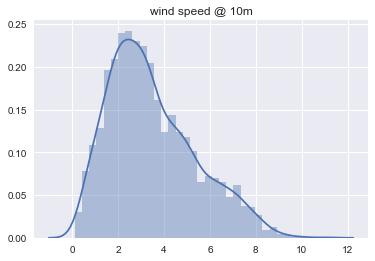

In [3]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

sns.distplot(towmetds['F'][:, -2])
plt.title('wind speed @ 10m')
plt.show()

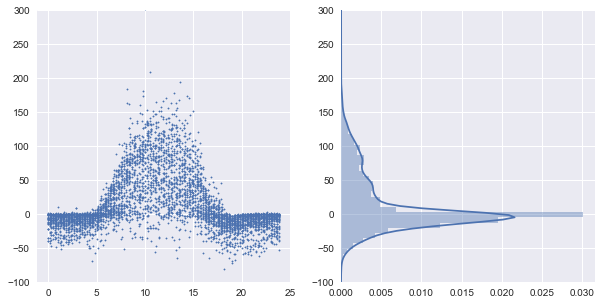

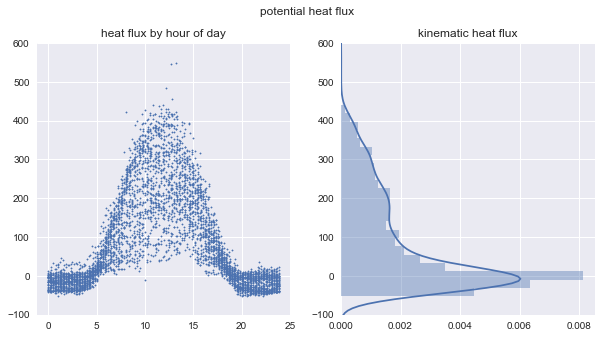

In [4]:
plt.figure(figsize=(10, 5))
plt.title('kinematic heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['H'][:], s=2)
plt.ylim(-100, 300)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['H'][:], vertical=True)
plt.ylim(-100, 300)
plt.show()

plt.figure(figsize=(10, 5))
plt.suptitle('potential heat flux')
plt.subplot(1, 2, 1)
plt.title('heat flux by hour of day')
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.title('kinematic heat flux')
plt.ylim(-100, 600)
plt.show()

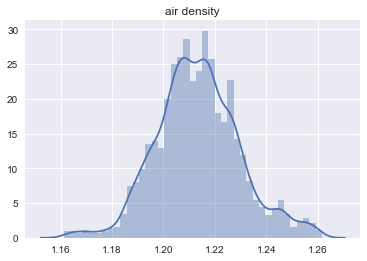

In [5]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

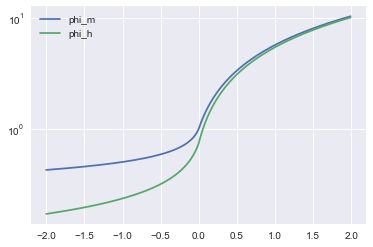

In [6]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

wind and temperature profile

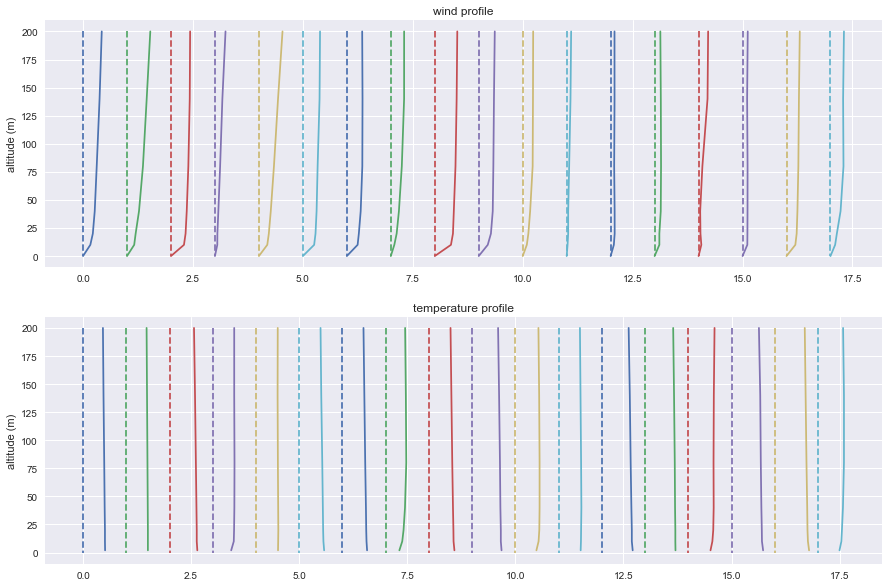

In [7]:
plt.figure(figsize=(15, 5))


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

for i, tt in enumerate(towmetds['time'][::250]):
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 20 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 30 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

wind/temperature profile gradient

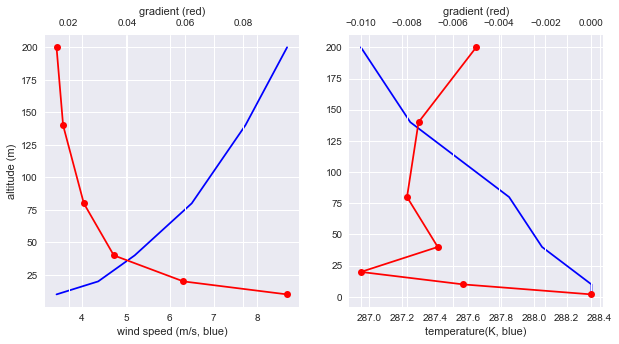

In [8]:
def get_derivative(xs, ys):
    dxdy = []
    for i in range(len(xs)):
        if i == 0:
            d = (ys[i] - ys[i + 1]) / (xs[i] - xs[i + 1])
        elif i == len(xs) - 1:
            d = (ys[i - 1] - ys[i]) / (xs[i - 1] - xs[i])
        else:
            d = (ys[i - 1] - ys[i + 1]) / (xs[i - 1] - xs[i + 1])

        dxdy.append(d)
    
    return dxdy


tt = towmetds['time'][14]

ws = towmetds['F'][tt][:-1]
hw = towmetds['z'][:-1]

ts = towmetds['TA'][tt]
ht = towmetds['z'][:]

dwdz = get_derivative(hw, ws)
dtdz = get_derivative(ht, ts)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax1.set_ylabel('altitude (m)')
ax1.plot(ws, hw, 'x-', c='b')
ax1.set_xlabel('wind speed (m/s, blue)')
ax12 = ax1.twiny()
ax12.plot(dwdz, hw, 'o-', c='r')
ax12.set_xlabel('gradient (red)')

ax2.plot(ts, ht, 'x-', c='b')
ax2.set_xlabel('temperature(K, blue)')
ax22 = ax2.twiny()
ax22.plot(dtdz, ht, 'o-', c='r')
ax22.set_xlabel('gradient (red)')

plt.show()

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [46]:
measurement_cols = ['air_dens', 'H', 'LE', 'ustar', 'wind', 'surf_temp', 'soil_temp']
index_cols = ['ds', 'year', 'month', 'daym', 'hday', 'tt']
computed_cols = ['phi_m', 'phi_h', 'zL_m', 'zL_h', 'dwdz', 'dtdz', 'lval']
source_cols = ['IUST', 'ILE', 'IH', 'ITA_2', 'ITA_1', 'IF_2', 'ITA002', 'IP0']
additional_cols = ['dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux', 'soilheat', 'netrad']
RowRecord = namedtuple('RowRecord', index_cols + measurement_cols + computed_cols + source_cols + additional_cols)


def process(month):
    try:
        towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
        #soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    for i, tt in enumerate(towmetds['time']):
        surf_temp = 273.15 + meteods['TA002'][tt]  # K
        #soil_temp = 273.15 + soilds['TS02'][tt]  # K
        air_dens = 100 * meteods['P0'][tt] / (287.058 * surf_temp)  # kg.m-3

        # following hogstrom 1988
        # except for the minus sign, which is supposed to be there
        virtual_potential_temperature_flux = (
            fluxds['H'][tt] + 0.07 * fluxds['LE'][tt]
        ) / (1005 * air_dens)

        lval = -fluxds['UST'][tt]**3 * surf_temp / (
            0.4 * 9.81 * virtual_potential_temperature_flux
        )  # m

        assert towmetds['z'][-2] == 10 and towmetds['z'][-1]  == 2

        # compute only at lowest layer (10m)
        # because H, LE, L are computed with surface measurements

        # because of no-slip condition, wind at surface is 0
        # no need to account for the roughness length (?, ~0.1m anyways)
        dwdz = towmetds['F'][tt, -2] / 10
        zL_m = towmetds['z'][-2] / (2 * lval)
        phi_m = dwdz * 0.4 * towmetds['z'][-2] / (2 * fluxds['UST'][tt])

        dz = towmetds['z'][-2] - towmetds['z'][-1]
        dt = towmetds['TA'][tt][-2] - towmetds['TA'][tt][-1]
        dtdz = dt / dz
        zL_h = (towmetds['z'][-1] + dz / 2) / lval
        phi_h = -(
            dtdz * 0.4 * (towmetds['z'][-1] + dz / 2) * fluxds['UST'][tt] * 1005 * air_dens
            / fluxds['H'][tt]
        )

        yield RowRecord(
            ds=month,
            year=month[:4],
            month=month[4:],
            daym=int(tt / 24),
            hday=tt % 24,
            tt=tt,

            air_dens=air_dens,
            H=fluxds['H'][tt],
            LE=fluxds['LE'][tt],
            ustar=fluxds['UST'][tt],
            surf_temp=surf_temp,
            soil_temp=None, #soil_temp,
            wind=towmetds['F'][tt, -2],

            lval=lval,
            dwdz=dwdz,
            phi_m=phi_m,
            zL_m=zL_m,
            dtdz=dtdz,
            zL_h=zL_h,
            phi_h=phi_h,

            IUST=fluxds['IUST'][tt],
            ILE=fluxds['ILE'][tt],
            IH=fluxds['IH'][tt],
            ITA_2=towmetds['ITA'][tt][-2],
            ITA_1=towmetds['ITA'][tt][-1],
            IF_2=towmetds['IF'][tt][-2],
            ITA002=meteods['ITA002'][tt],
            IP0=meteods['IP0'][tt],
            
            co2flux=fluxds['FC'][tt],
            soilheat=fluxds['G0'][tt],
            netrad=fluxds['QN'][tt],
            spec_hum=towmetds['Q'][tt][-1],
            dewpoint=towmetds['TD'][tt][-1],
            rel_hum=towmetds['RH'][tt][-1],
            press=meteods['P0'][tt],
            rain=meteods['RAIN'][tt],
        )

In [55]:
dframe_path = 'data/cabauw/processed.csv'

if not os.path.exists(dframe_path):
    print('recomputing data (you take a coffee)')
    import findspark
    findspark.init()

    from pyspark import SparkContext, SparkConf
    
    sc = SparkContext(conf=SparkConf().setMaster('local[7]').set('spark.driver.memory', '14g'))
    all_months = set(f[-6-3:-3] for f in os.listdir('data/cabauw') if f.endswith('.nc'))

    try:
        df_rows = sc.parallelize(all_months, len(all_months)).flatMap(process).collect()
    finally:
        sc.stop()

    df = pd.DataFrame(df_rows)
    df.to_csv(dframe_path, index=False)


try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

we can remove some data known to be of bad quality, i.e. $u_*<0.1$ and $\vert H\vert<10$

In [48]:
df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]

we also remove data from 201603 as it contains bad measurements for the fluxes

In [49]:
df[df.ds == 201603][['H', 'LE']].describe().T

,count,mean,std,min,25%,50%,75%,max
H,3342.0,316.126351,6204.178619,-1552.988037,-59.778019,-22.506733,24.910757,144691.765625
LE,3324.0,24.658386,426.899671,-6601.955600,-23.895859,29.174152,113.092880,1549.666400


In [50]:
df = df[df.ds != 201603]

In [51]:
df[measurement_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
air_dens,520998.0,1.240189,0.030805,1.145826,1.218874,1.237440,1.259142,1.397611
H,520998.0,1.995475,46.265667,-459.999756,-26.539051,-15.339976,26.067751,459.924530
LE,520998.0,74.735474,116.087498,-117.415665,-5.016693,22.696487,129.485170,595.862700
ustar,520998.0,0.308456,0.143101,0.100004,0.200044,0.284211,0.386544,1.313813
wind,520998.0,5.170168,2.344853,1.002586,3.440000,4.720000,6.430000,19.219999
surf_temp,520998.0,284.857396,6.680565,259.350000,280.150000,284.750000,289.650000,306.550002
soil_temp,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df[computed_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
phi_m,520998.0,3.455524,0.797578,0.610934,2.938480,3.376854,3.905479,12.163948
phi_h,520998.0,1.119692,0.895195,-13.670445,0.671202,1.029036,1.483542,21.213034
zL_m,520998.0,-0.015646,0.422432,-10.350799,-0.061496,0.020486,0.096772,3.488068
zL_h,520998.0,-0.018775,0.506918,-12.420959,-0.073796,0.024584,0.116127,4.185682
dwdz,520998.0,0.517017,0.234485,0.100259,0.344000,0.472000,0.643000,1.922000
dtdz,520998.0,0.005663,0.058772,-0.287769,-0.037498,0.012501,0.037502,0.412498
lval,520998.0,111.239142,1347.389044,-56474.352644,-19.579466,25.111862,126.304888,326253.666461


In [53]:
df[index_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ds,520998.0,200894.975493,484.942055,200101.0,200504.0,200905.000000,201307.000000,201712.000000
year,520998.0,2008.885907,4.848961,2001.0,2005.0,2009.000000,2013.000000,2017.000000
month,520998.0,6.384750,3.397912,1.0,4.0,6.000000,9.000000,12.000000
daym,520998.0,14.729907,8.747422,0.0,7.0,15.000000,22.000000,30.000000
hday,520998.0,11.969246,6.941025,0.0,6.0,12.000015,18.000004,23.833374
tt,520998.0,365.487010,210.027255,0.0,189.0,363.000000,543.291656,743.833374


In [54]:
df[source_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
IUST,520998.0,2.266051,0.700490,2.0,2.0,2.0,2.0,7.0
ILE,520998.0,2.448804,1.253608,2.0,2.0,2.0,2.0,7.0
IH,520998.0,2.428443,1.222328,2.0,2.0,2.0,2.0,7.0
ITA_2,520998.0,2.017136,0.267394,2.0,2.0,2.0,2.0,7.0
ITA_1,520998.0,2.013232,0.225712,2.0,2.0,2.0,2.0,7.0
IF_2,520998.0,2.013981,0.227219,2.0,2.0,2.0,2.0,7.0
ITA002,520998.0,2.013232,0.225712,2.0,2.0,2.0,2.0,7.0
IP0,520998.0,3.040492,0.395780,3.0,3.0,3.0,3.0,7.0


plot correlation matrix between data, computed values, and time of year (to check seasonality)

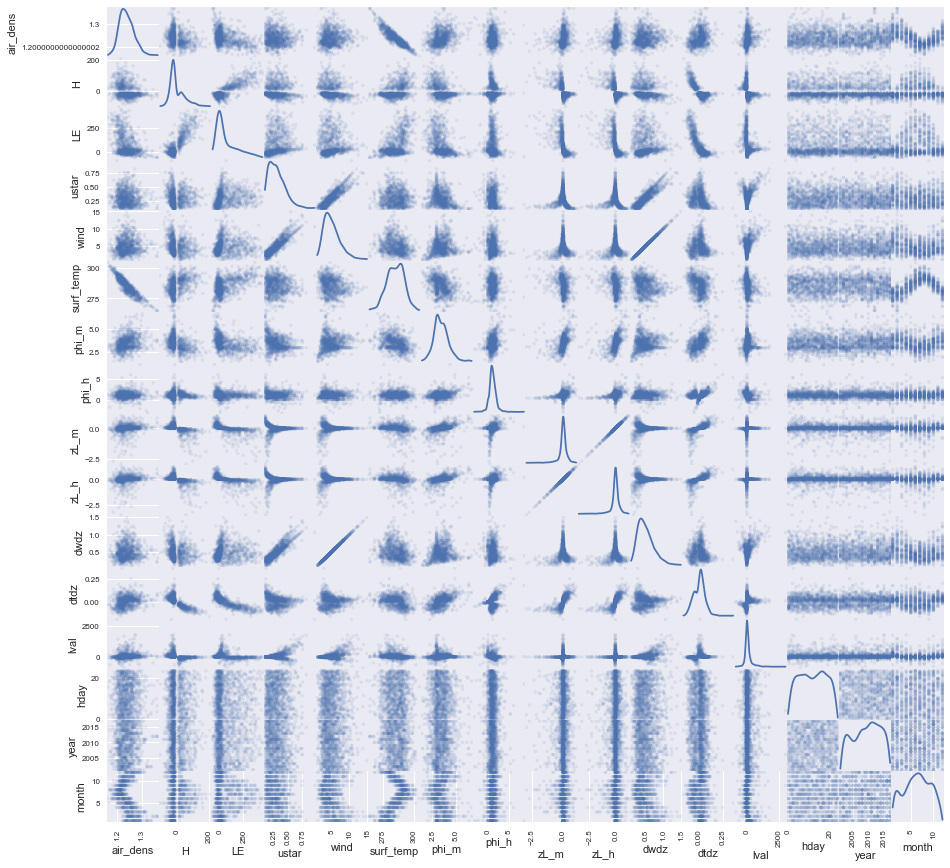

In [18]:
_ = pd.plotting.scatter_matrix(
    df.sample(1000)[measurement_cols + computed_cols + ['hday', 'year', 'month']].drop('soil_temp', axis=1),
    figsize=(15, 15), alpha=0.1, diagonal='kde'
)

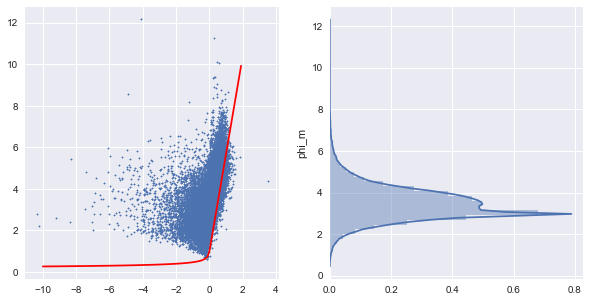

In [19]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 19.3 * zL, -0.25)
    else:
        return 1 + 4.7 * zL


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL_m, df.phi_m, s=1)
xx = np.arange(-10, 2, 0.1)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
#plt.xlim(-2, 2)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_m.dropna(), vertical=True)
plt.show()

at negative z/L, phi should go to 0 following the red line, but phi is basically wind/ustar, which are quite well correlated:

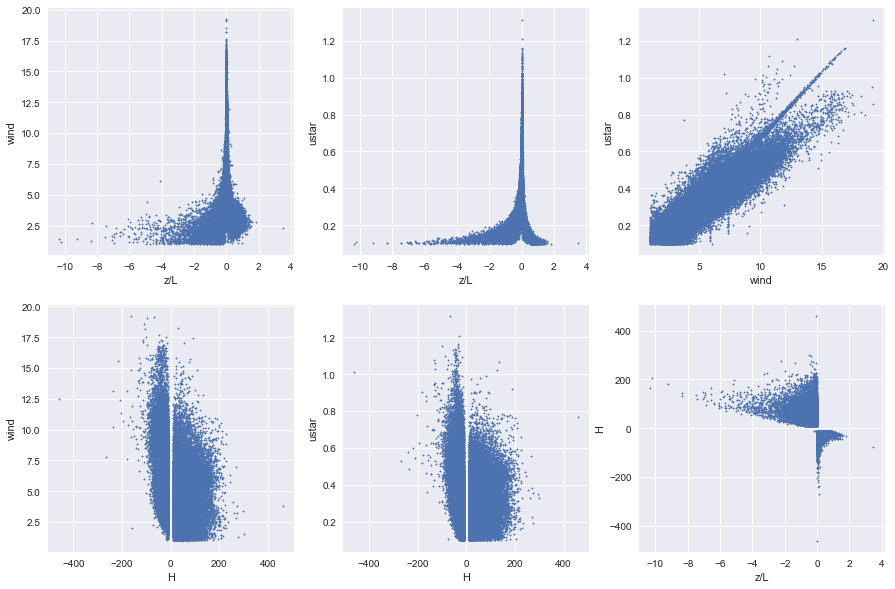

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.ylabel('wind'); plt.xlabel('z/L')
plt.scatter(df.zL_m, df.wind, s=1)

plt.subplot(2, 3, 2)
plt.ylabel('ustar'); plt.xlabel('z/L')
plt.scatter(df.zL_m, df.ustar, s=1)

plt.subplot(2, 3, 3)
plt.scatter(df.wind, df.ustar, s=1)
plt.ylabel('ustar'); plt.xlabel('wind')

plt.subplot(2, 3, 4)
plt.scatter(df.H, df.wind, s=1)
plt.xlabel('H'); plt.ylabel('wind')

plt.subplot(2, 3, 5)
plt.scatter(df.H, df.ustar, s=1)
plt.xlabel('H'); plt.ylabel('ustar')

plt.subplot(2, 3, 6)
plt.scatter(df.zL_m, df.H, s=1)
plt.ylabel('H'); plt.xlabel('z/L')
plt.show()

in order to have phi_m close to 0 when z/L is negative, you would need no wind or large u*, none of which is true

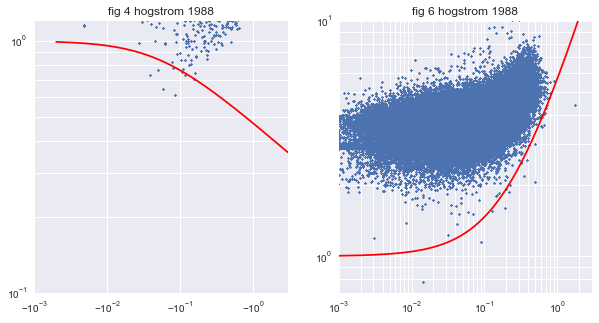

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL_m / 2, df.phi_m, s=2)
xx = np.arange(-3, -0.001, 0.001)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
plt.xlim(-3, -0.001)
plt.xscale('symlog', linthreshx=0.001)
plt.ylim(0.1, 1.2)
plt.yscale('log')
plt.title('fig 4 hogstrom 1988')
plt.gca().invert_xaxis()
plt.grid(True, 'both')

plt.subplot(1, 2, 2)
plt.scatter(df.zL_m / 2, df.phi_m, s=2)
xx = np.arange(0.001, 3, 0.001)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
plt.xlim(0.001, 3)
plt.xscale('log')
plt.ylim(0.7, 10)
plt.yscale('log')
plt.title('fig 6 hogstrom 1988')
plt.grid(True, 'both')
plt.show()

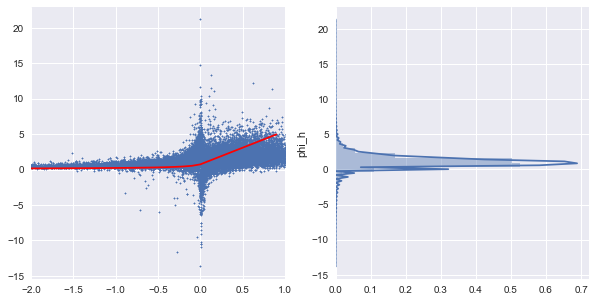

In [22]:
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL

    
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
xx  = np.arange(-2, 1, 0.1)
plt.scatter(df.zL_h, df.phi_h, s=1)
plt.plot(xx, list(map(phi_h, xx)), 'r')
plt.xlim(-2, 1)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_h.dropna(), vertical=True)
plt.show()

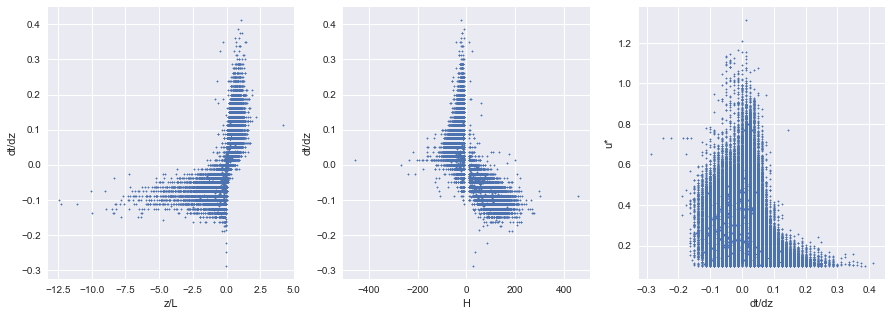

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df.zL_h, df.dtdz, s=1)
plt.xlabel('z/L'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 2)
plt.scatter(df.H, df.dtdz, s=1)
plt.xlabel('H'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 3)
plt.scatter(df.dtdz, df.ustar, s=1)
plt.xlabel('dt/dz'); plt.ylabel('u*')
plt.show()

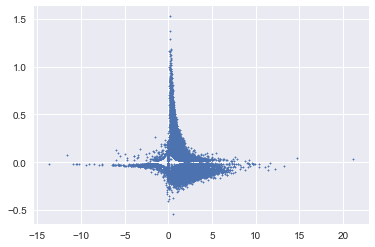

In [24]:
plt.scatter(df.phi_h, df.H / (1005 * df.air_dens * df.ustar), s=1)

very strong correlation with the previous sample, and 6 days seasonality very clear

## Checking $\phi_m$

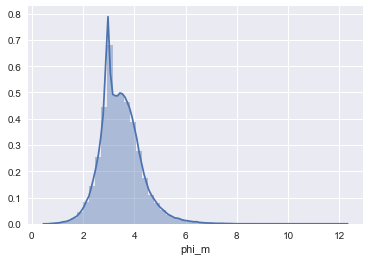

In [25]:
sns.distplot(df.phi_m.dropna())
plt.xlabel('phi_m')
plt.show()

we can compare the CDF of the variables by creating groups based on the range of $\phi_m$. we select the interval (0, 1) because it (supposedly) contains values of phi_m for unstable conditions

In [26]:
ints = [0, 1, 4, 8, 25]
print('interv.\tcount')
for low, high in zip(ints[:-1], ints[1:]):
    count = len(df[(df.phi_m >= low) & (df.phi_m < high)])
    print('[%d,%d)\t%d' % (low, high, count))

interv.	count
[0,1)	312
[1,4)	409866
[4,8)	110688
[8,25)	132


In [27]:
def plot_cdf(rvars, labels=None, ordinal=False):
    ''' plot the empirical cdf and a boxplot of multple random variables
        in the same chart, to ease comparison

        rvars contains a list of samples for each r.v.
        labels contains a label for each r.v.
    '''
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax1 = plt.subplot(gs[0])

    if ordinal:
        all_levels = sorted(set(v for var in rvars for v in var))
        level_map = dict(zip(all_levels, range(len(all_levels))))
        inv_level_map = dict(zip(range(len(all_levels)), all_levels))
        rvars = [list(map(level_map.get, var)) for var in rvars]

    for i, values in enumerate(rvars):
        xx = sorted(values)
        yy = np.arange(len(values)) / len(values)
        lbl = labels[i] if labels is not None else None
        
        ax1.plot(xx, yy, label=lbl)

    if labels is not None:
        ax1.legend()

    ax2 = plt.subplot(gs[1])
    sns.boxplot(data=rvars, ax=ax2, orient='h')

    if ordinal:
        ticklb = [
            # ticks are float, get label only on integral ticks
            (inv_level_map.get(int(t), '') if abs(int(t) - t) < 1e-9 else '')
            for t in ax1.get_xticks()
        ]

        ax1.set_xticklabels(ticklb)
        ax2.set_xticklabels(ticklb)

    return ax1, ax2


def inspect_col(colname, partition_by, interval, show=True, fig=None):
    old_pal = sns.color_palette()
    sns.set_palette('GnBu_d')

    vs = [
        df[colname][
            (df[partition_by] >= low) &
            (df[partition_by] < high)
        ].dropna()
        for low, high in zip(interval[:-1], interval[1:])
    ]

    if fig is None:
        fig = plt.figure(figsize=(7, 5))

    ax1, ax2 = plot_cdf(
        vs, list(map(str, zip(interval[:-1], interval[1:]))),
        ordinal=colname in source_cols + ['ds']
    )
    ax1.set_title(colname)
    sns.set_palette(old_pal)
    
    if show:
        plt.show()
    
    return fig, ax1, ax2

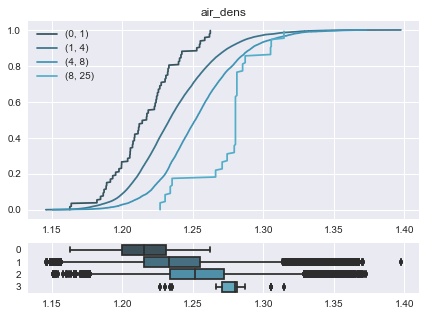

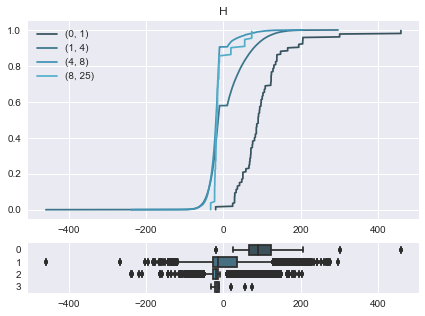

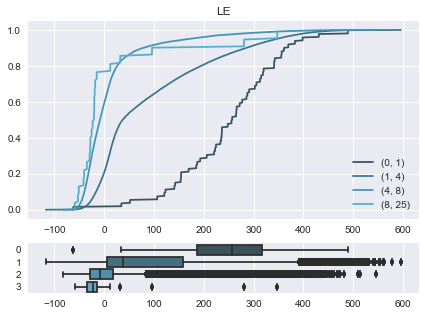

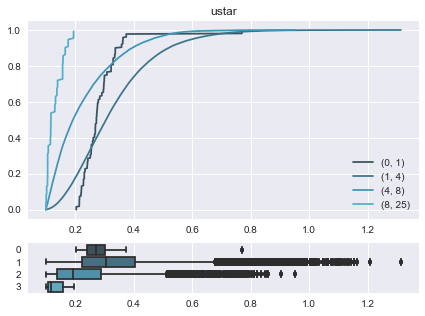

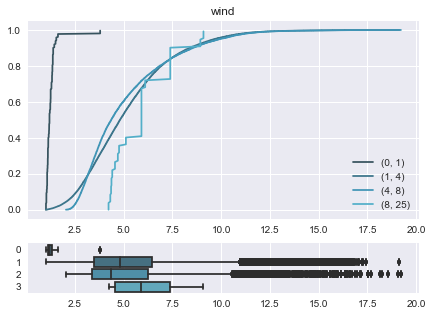

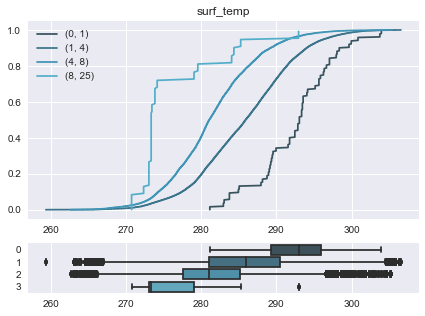

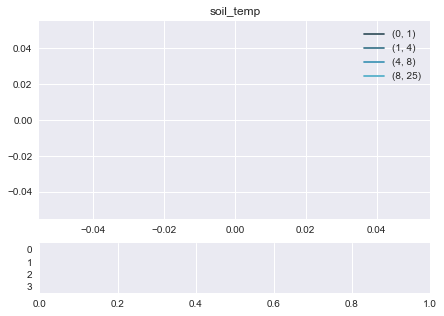

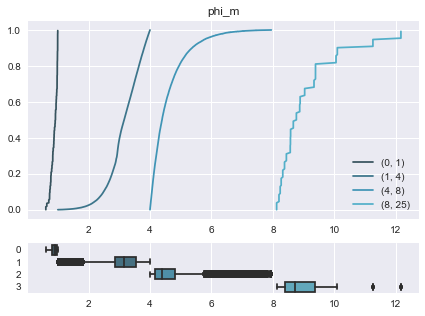

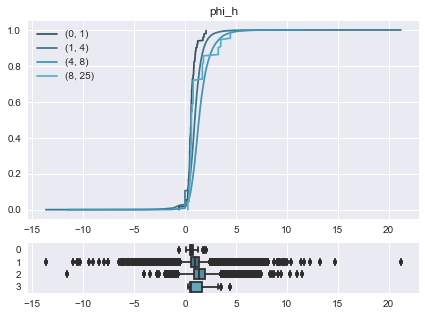

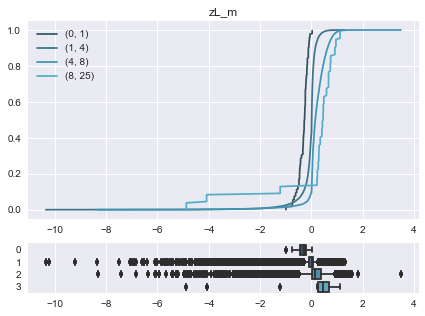

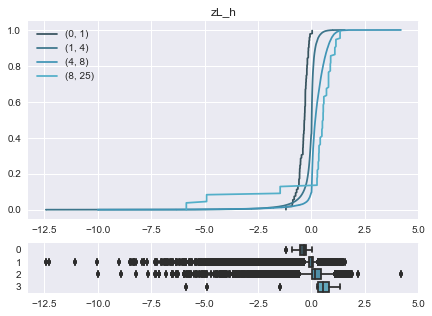

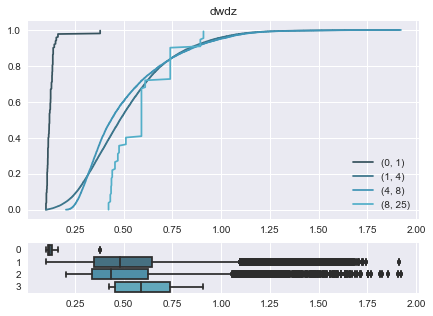

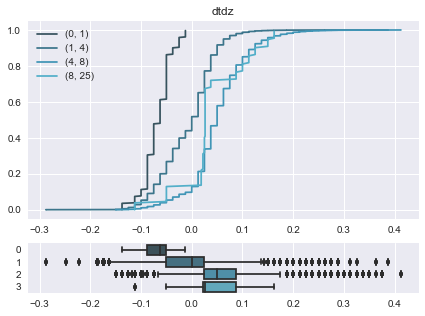

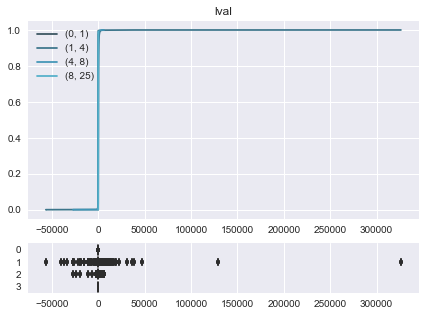

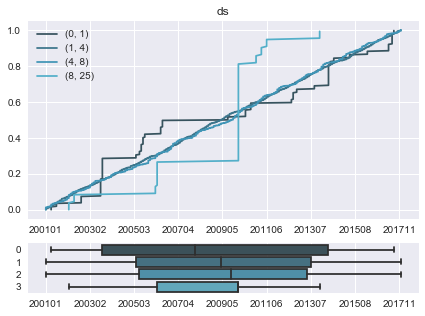

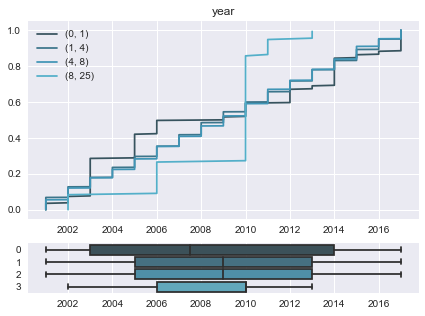

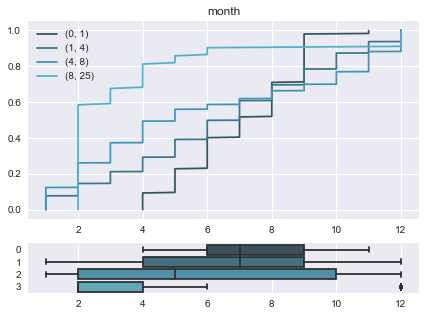

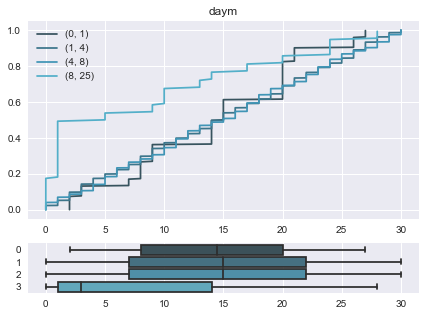

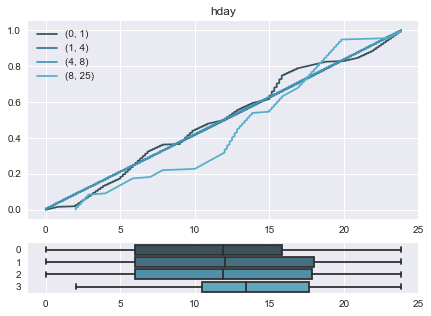

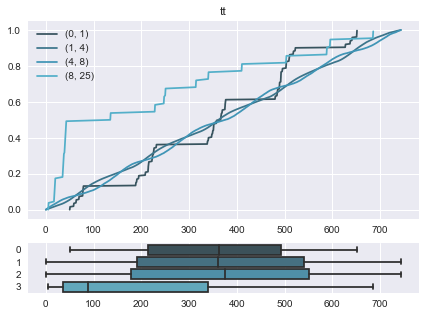

In [28]:
for col in measurement_cols + computed_cols + index_cols:
    inspect_col(col, 'phi_m', ints)

seems like the source of the data (I-columns) does not play a big role in differentiating the phi levels

we see larger $\phi_m$s associated with
 - denser air
 - colder surface temperature
 - more wind
 - larger and mostly positive temperature gradient
 - lower heat fluxes

this is consistent with what we would expect, as $\phi_m$ is expected to be higher in stable condtions

highest $u_*$ in moderately stable conditions, low values in unstable and highly stable conditions; this makes sense, because in unstable conditions most tke comes from eddy fluxes caused by buoyancy, and in very stable conditions we have a calm surface layer with little turbulence. in both cases wind shear does not generate much turbulence

In [29]:
width = 4
(df[(df.phi_m >= 1)]
     .groupby((df.phi_m / width).astype(int))
     .ustar.mean()
     .rename(lambda x: '[%d, %d)' % (max(width*x, 1), width*(x+1))))

phi_m
[1, 4)      0.330108
[4, 8)      0.228557
[8, 12)     0.131266
[12, 16)    0.100296
Name: ustar, dtype: float64

there seems to be a curious pattern in the time of the month when data with small and large phi values is obtained:

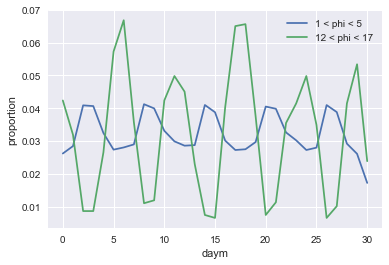

In [30]:
small_mask = (df.phi_m > 1) & (df.phi_m < 5)
large_mask = (df.phi_m > 5) & (df.phi_m < 8)

plt.plot(df[small_mask].groupby(df.daym).size() / len(df[small_mask]), label='1 < phi < 5')
plt.plot(df[large_mask].groupby(df.daym).size() / len(df[large_mask]), label='12 < phi < 17')
plt.xlabel('daym')
plt.ylabel('proportion')
plt.legend()
plt.show()

this pattern happens for other measured variables

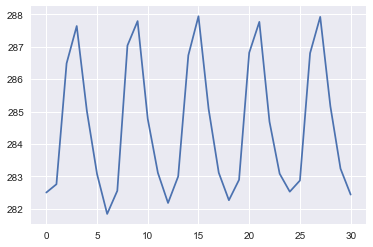

In [31]:
plt.plot(df.groupby(df.daym).surf_temp.mean())

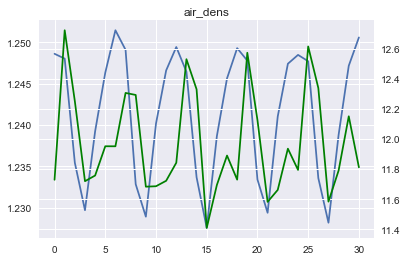

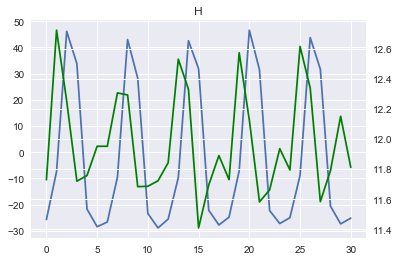

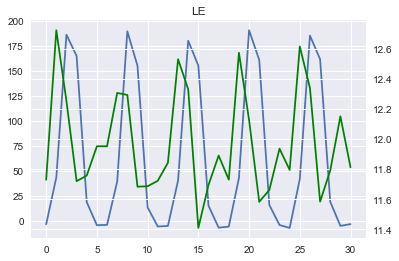

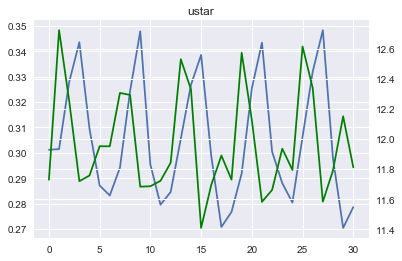

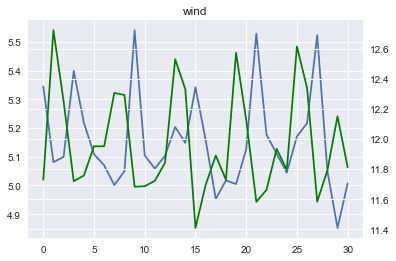

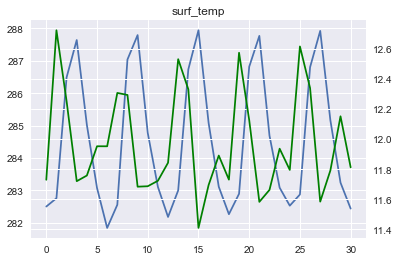

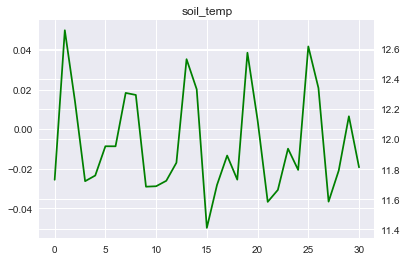

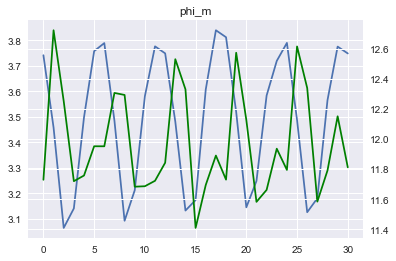

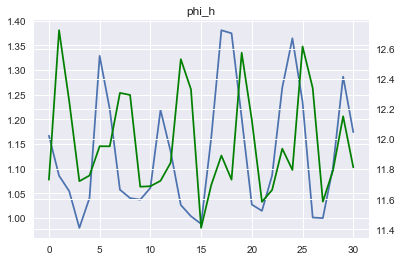

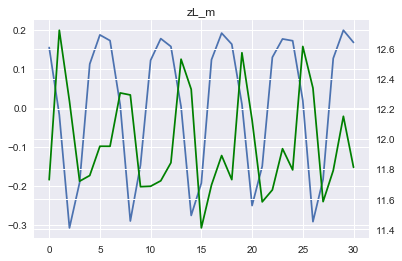

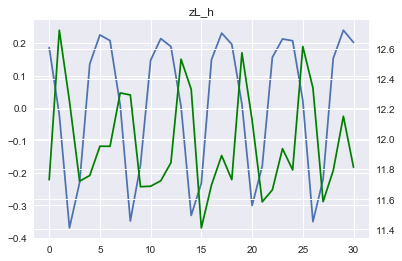

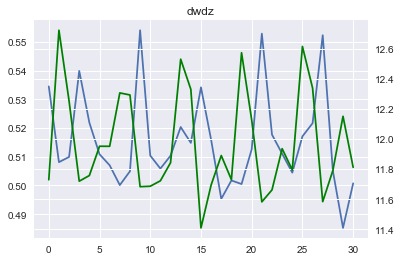

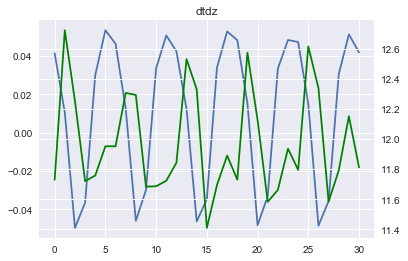

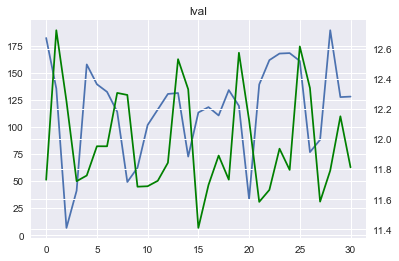

In [40]:
for var in measurement_cols + computed_cols:
    plt.plot(df.groupby(df.daym)[var].mean())
    ax2=plt.gca().twinx()
    ax2.plot(df.groupby(df.daym).hday.mean(), c='g')
    plt.title(var)
    plt.show()

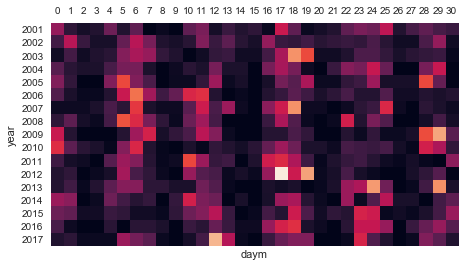

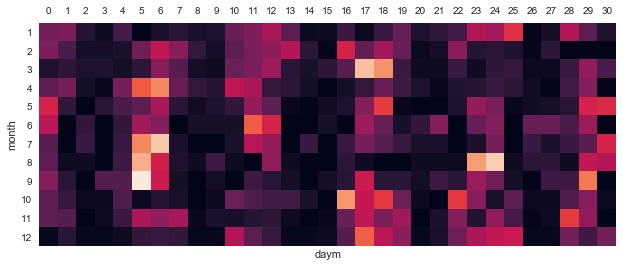

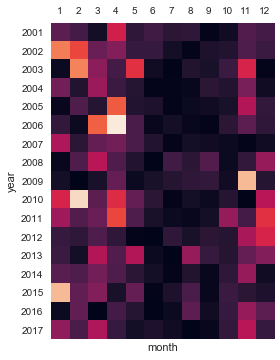

In [33]:
def matcount(row, col, transpose=False, norm=False):
    mat = (df[large_mask]
        .groupby(row)[col].value_counts()
        .rename('count').reset_index()
        .pivot(index=col, columns=row)
        .fillna(0).as_matrix())

    if norm:
        mat = mat / mat.sum(axis=0)
    
    if transpose:
        mat = mat.T
        row, col = col, row

    plt.matshow(mat)
    plt.xticks(range(len(df[row].unique())), sorted(df[row].unique()))
    plt.yticks(range(len(df[col].unique())), sorted(df[col].unique()))
    plt.xlabel(row)
    plt.ylabel(col)
    plt.grid(False)


matcount('year', 'daym', True, True) # normalize by year, transpose to plot horizontally
matcount('month', 'daym', True, True) # normalize by month, transpose to plot horizontally
matcount('month', 'year')

seems like the 6 days seasonality does not depend on the year nor on the month of the year, if we take into account the fact that some months have way more measures than others

what bothers me is that this 6 days cycle repeats more or less regularly for more than 15 years

<Container object of 40 artists>

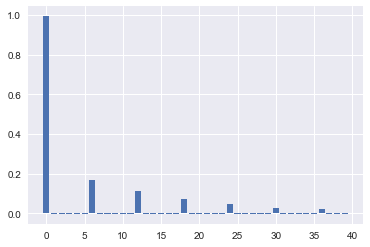

In [34]:
vs = pacf(df.sort_values(['ds', 'tt']).wind)
plt.bar(range(len(vs) - 1), vs[1:])

## inspect z/L (for phi_m)

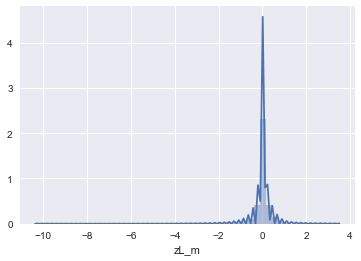

In [35]:
sns.distplot(df.zL_m)

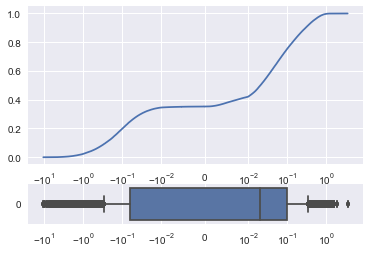

In [36]:
ax1, ax2 = plot_cdf([df.zL_m], labels=None)
ax1.set_xscale('symlog', linthreshx=1e-2)
ax2.set_xscale('symlog', linthreshx=1e-2)

In [37]:
bins = [
    -21, -1, 0, 1, 10
]

(df.zL_m
     .groupby(np.digitize(df.zL_m, bins))
     .size().rename(lambda b: '[%6.0e, %6.0e)' % (bins[b - 1], bins[b])))

[-2e+01, -1e+00)     12006
[-1e+00,  0e+00)    171816
[ 0e+00,  1e+00)    335958
[ 1e+00,  1e+01)      1218
Name: zL_m, dtype: int64

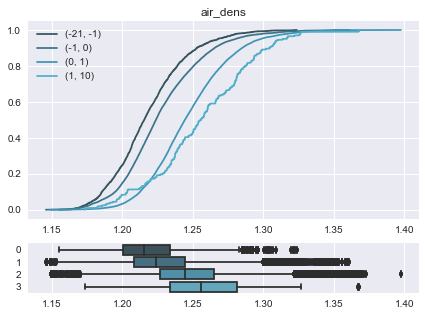

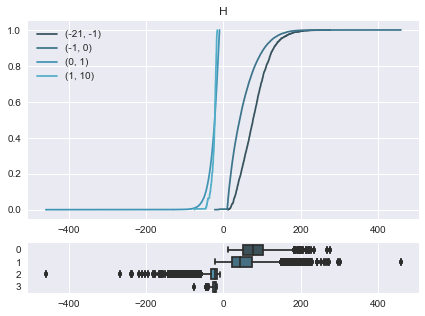

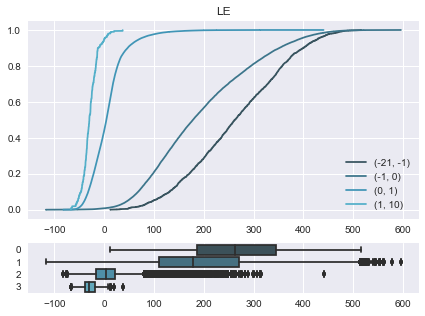

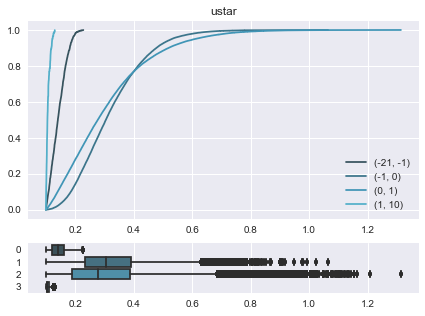

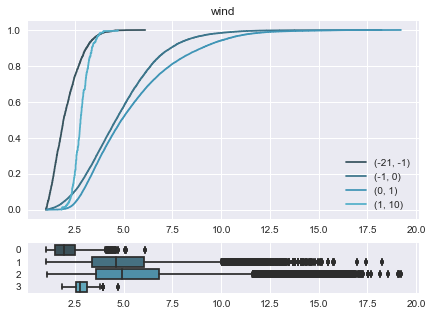

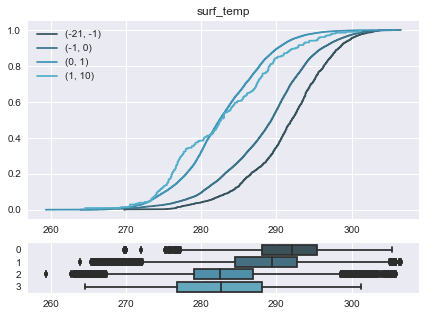

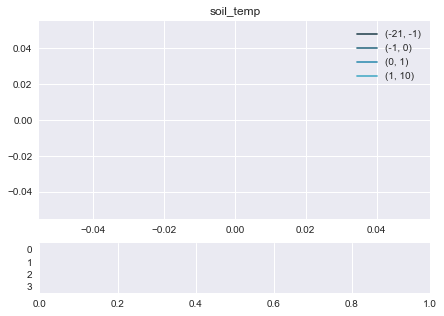

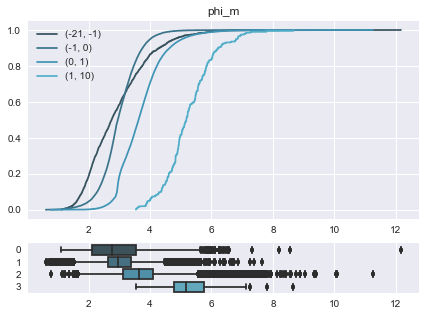

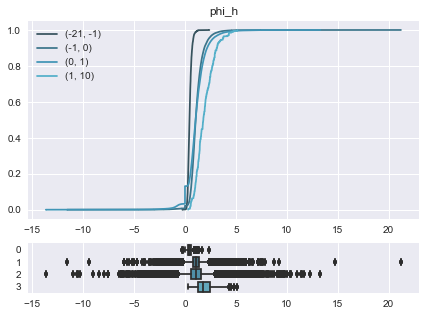

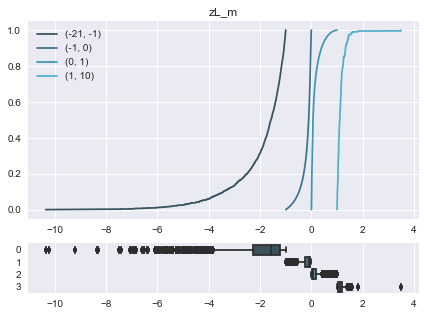

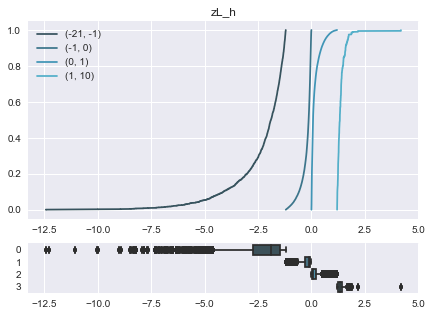

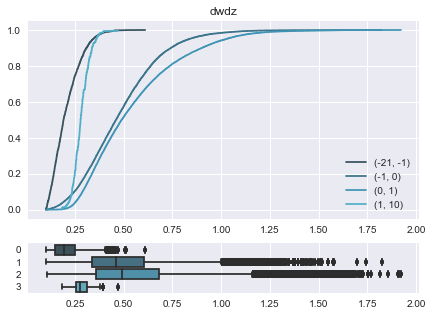

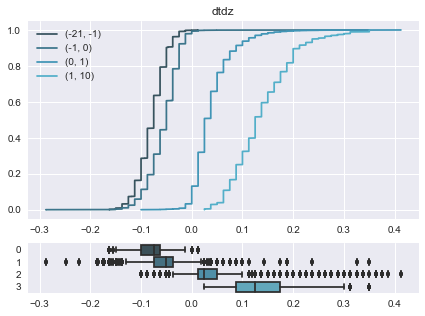

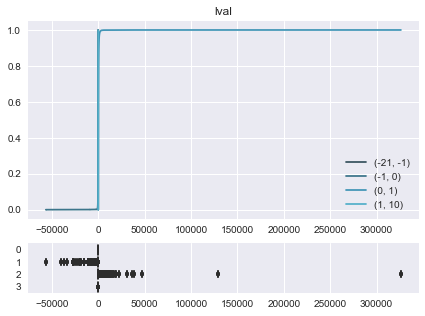

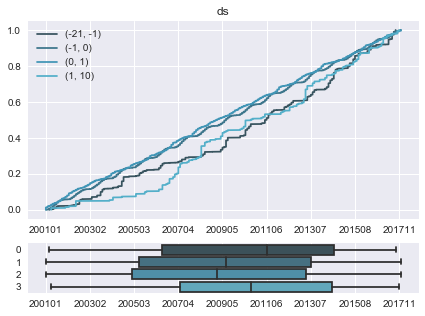

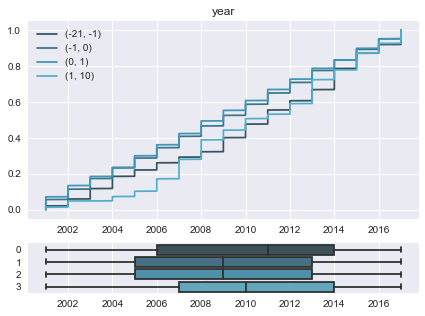

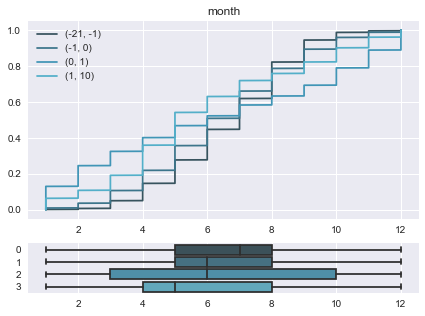

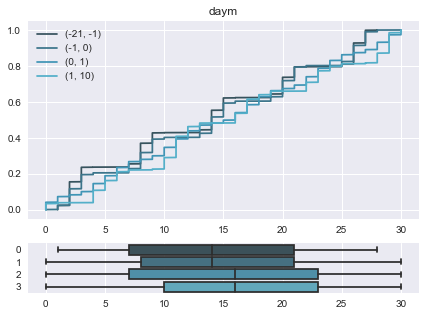

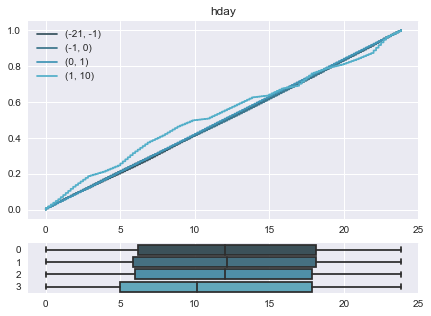

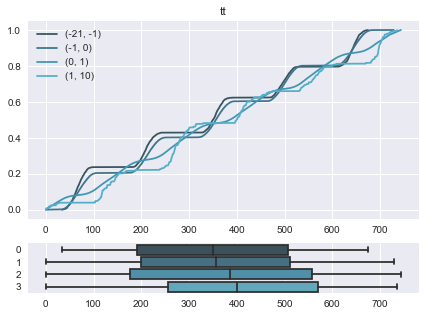

In [38]:
for col in measurement_cols + computed_cols + index_cols:
    inspect_col(col, 'zL_m', bins)

In [39]:
(df.groupby(np.digitize(df.zL_m, bins))
     [['ustar', 'wind', 'LE', 'surf_temp', 'phi_m']].mean()
     .rename(lambda b: '[%6.0f, %6.0f)' % (bins[b - 1], bins[b])))

,ustar,wind,LE,surf_temp,phi_m
"[ -21, -1)",0.143527,2.065313,264.074708,291.467616,2.925641
"[ -1, 0)",0.321157,4.819238,194.884710,288.561582,2.995698
"[ 0, 1)",0.308581,5.469079,6.897616,282.733839,3.703083
"[ 1, 10)",0.107883,2.830841,-28.792460,282.907635,5.259912
